## How SSD works?

Image classification in computer vision takes an image and predicts the object in an image, while object detection not only predicts the object but also finds their location in terms of bounding boxes. For example, when we build a cat classifier, we take images and predict their class, while an object detection model would also tell us the location of the cat.

<img src="img/cat.png">

For illustrative purpose, assuming there is at most one class and one object in an image, the output of an object detection model should be 
- Probablity that there is an object, 
- Height of the bounding box, 
- Width of the bounding box, 
- Horizontal coordinate of the center point of the bounding box,
- Vertical coordinate of the center point of the bounding box.

It's natural to think of building an object detection model on the top of an image classification model. Once we have a good image classifier, a simple way to detect objects is to slide a 'window' across the image and classify whether the image in that window (cropped out region of the image) is of the desired type. Sounds simple! Well, there are at least two problems: 
- (1) How do you know the **size of the window** so that it always contains the object? Different types of objects (cat and vehicle). Even the same type of objects (e.g. sedan and truck) can be of varying sizes as well. 
- (2) **Aspect ratio** (the ratio of height to width of the bounding box). A lot of objects can be present in various shapes like a sitting person will have a different aspect ratio than standing person or sleeping person.

To solve these problems, we would have to try out different sizes/shapes of sliding window, which is very computationally intensive, especially with deep neural network. 

<img src="img/sliding-window.gif">

In practice, there are two types of mainstream object detection algorithms. Algorithms like R-CNN and Fast(er) R-CNN use a two stage approach - first to identify regions where objects are expected to be found and then detect objects only in those regions using convnet. The other type of object detection networks such as YOLO (You Only Look Once) and SSD (Single-Shot Detector) use a fully convolutional approach in which the network is able to find all objects within an image in one pass (hence ‘single-shot’ or ‘look once’) through the convnet. The region proposal algorithms usually have slightly better accuracy but slower to run, while algorithms like SSD is more efficient and has reasonable accuracy and that's what we are going to focus on in this section.

Before we dive into SSD, let's first get a conceptual understanding of what a **convolutional neural network (CNN)** does. 
<img src="img/cnn.png">

Instead of using a region proposal networks to come up with candidate locations of prospective objects, the Single Shot MultiBox Detector (on which the `SingleShotDetector` is modeled) divides up the image using a grid with each grid cell responsible for predicting which object (if any) lies in it and where. 

**Backbone**
SSD uses a pre-trained image classification network as a feature extractor. This is typically a network like ResNet trained on ImageNet from which the final fully connected layer to come up with the predicted class of an input image has been removed. We are thus left with a deep neural network that is able to extract semantic meaning from the input image while preserving the spatial structure of the image albeit at a lower resolution. For ResNet34 the backbone results in a 256 7x7 'feature maps' of activations for each input image. Each of these 256 feature maps can be interpreted as a grid of 7x7 activations that fire up when a particular feature is detected in the image. In the SSD architecture, one or more convolutional layers are added to this bankbone and the outputs are interpreted as the bounding boxes and classes of objects in the spatial location of the final layers activations.

**Receptive Field**
Convolutional neural networks preserve the spatial structure of an image because of the way the convolution operation is applied. A learnable filter slides over the image from left to right and top to bottom and the activations represent how similar that part of the image is to the filter. Each activation in the output feature map is thus 'looking at' that region of the previous feature map (and ultimately the image because a deep CNN has multiple such convolutional layers). The part of the image that is ultimately responsible for an activation in a feature map is referred to as the 'receptive field' of that activation. Each activation in the output feature map has 'seen' that part of the image more than any other activation and is it natural to expect that activation to contain the most information needed to detect objects in its receptive field. This is the central premise of the SSD architecture.

As it's possible for multiple objects to occupy a grid cell, and for the objects to have a different sizes or aspect ratios, each grid cell has several assigned anchor boxes (also known as prior boxes) - one for each possible object size and aspect ratio within that grid cell. SSD uses a matching phase while training, to match the appropriate anchor box with the bounding boxes of each ground truth object within an image. Essentially, the anchor box with the highest degree of overlap with an object is responsible for predicting that object’s class and its location. This property is used for training the network and for predicting the detected objects and their locations once the network has been trained.

Having a knowledge of the SingleShotDetector architecture and how the anchor boxes are specified using grid cells, aspect ratios and zoom levels allows one to design a suitable model for the object detection task at hand. If the objects you are detection are all of roughly the same size, you can simplify the network architecture by using just one scale of the anchor boxes.


**Grid cells**
A simple way to detect multiple objects in an image is to divide the image using a grid and have each grid cell be responsible for detecting objects in that region of the image. Detection objects simply means predicting the class and location of an object within that region. If no object is present, we consider it as the background class and the location is ignored.

In the SSD architecture, we add additional convolutional layers to the backbone network and architect the additional layers in such a manner that the spatial size of the final layer is the same as the size of the grid we are using. The depth of the final feature map is used to predict the class of the object within the grid cell and it’s bounding box. This allows SSD to be a fully convolutional network that is fast and efficient while taking advantage of the receptive field of each grid cell to detect objects within that grid cell.

For instance, we could use a 4x4 grid to detect objects in an image, when we see that their size is such that approximately 4 of them could occupy an image chip (on a side):
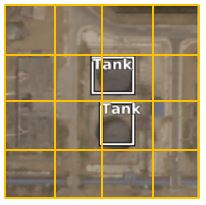  
Such an SSD architecture can be created using:

    ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]])

The grids parameter specifies the size of the grid cell, in this case 5x5. Additionally, we are specifying a zoom level of 1.0 and aspect ratio of 1.0:1.0. What this essentially means is that the network will create an anchor box (or prior box, as its known in other places) for each grid cell, which is the same size as the grid cell (zoom level of 1.0) and is square in shape with an aspect ratio of 1.0:1.0
The output activations along the depth of the final feature map are used to shift and scale (within a reasonable limit) this anchor box so it can approach the actual bounding box of the object even if it doesn’t exactly match with the anchor box. 

We might be interested in several layers or hierarchies of grid cells. For example, we could use a 4x4 grid to find smaller objects, a 2x2 grid to find mid sized objects and a 1x1 grid to find objects that cover the entire image. 

**Zoom levels/scales**
 
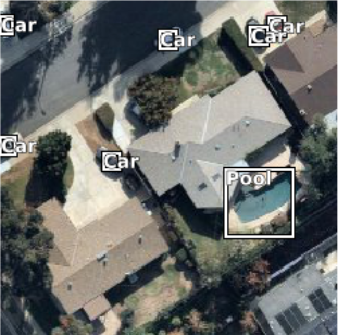
 <center><i>Cars and Pools have different zoom levels</i></center>
 
It is not necessary for the anchor boxes to have the same size as the grid cell. We might be interested in finding smaller or larger objects within a grid cell. The zooms parameter is used to specify how much the anchor boxes need to be scaled up or down with respect to each grid cell.

**Aspect ratios**

Not all objects are square in shape. Some are longer and some are wider, by varying degrees. The SSD architecture allows pre-defined aspect ratios of the anchor boxes to account for this. The ratios parameter can be used to specify the different aspect ratios of the anchor boxes associates with each grid cell at each zoom/scale level.
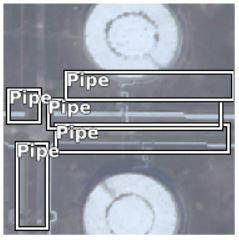
<center><i>Pipes could be oriented at different angles and their bounding boxes would have different aspect ratios</i></center>

Having multiple anchor boxes per grid cell with different aspect ratios and at different scales, while also allowing for multiple hierarchies of grid cells results in a profusion of potential anchor boxes that are candidates for matching the ground truth while training and for prediction. 